In [1]:
import os
os.chdir('/home/fsboedij/Data/MouseAtlas')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc
import copy
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gdown
import sankey
import anndata
import pandas as pd
import pandas as pd
from pySankey.sankey import sankey
from matplotlib.pyplot import rc_context
import seaborn as sns
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(5, 5))
torch.set_printoptions(precision=10, sci_mode=False, edgeitems=12)
pd.options.mode.chained_assignment = None
import scipy.sparse as sp

INFO:lightning_fabric.utilities.seed:Global seed set to 0
2024-08-20 18:34:47.896050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
 captum (see https://github.com/pytorch/captum).


In [2]:
directory = '/home/fsboedij/Data/MouseAtlas/Data/Individual_studies/preQC'

In [3]:
#Load each study objects and compile them in a list
studies = []
# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.h5ad'):  # Check if the file is a .h5ad file
        print(filename)
        filepath = os.path.join(directory, filename)
        adata_obj = sc.read(filepath)  # Load the .h5ad file
        #Replacing '.' to '-' to harmonise gene names in each study
        adata_obj.var_names = adata_obj.var_names.str.replace('.','-')
        studies.append(adata_obj) 

len(studies)

Mouse_fibrosis_final.h5ad
Ageing_final.h5ad
Mouse_Radiation_final.h5ad
Mouse_covid_final.h5ad
Mouse_TumorKO_final.h5ad
Mouse_copd_covid_final.h5ad
Mouse_Cancer_final.h5ad
Mouse_Hypoxia_final.h5ad
Mouse_SevereAsthma_final.h5ad
Mouse_Herpesvirus.h5ad
Mouse_influenza_final.h5ad
Mouse_COPD_final.h5ad
Mouse_CSSC.h5ad
Mouse_Post_Sendai_final.h5ad
Mouse_FibrosisAge_final.h5ad
Mouse_TB_final.h5ad
Mouse_Hyperoxia_final.h5ad


17

In [5]:
#Combine each study into one adata containing all studies and all genes
adata = studies[0].concatenate(
    studies[1:],  # Remaining AnnData objects
    index_unique=None,  # Keep cell indices unique
    join='outer',  # Include all genes (fill missing with fill_value)
    fill_value=0  # Fill missing values with 0
)

print(adata)

AnnData object with n_obs × n_vars = 885541 × 70224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'age', 'sex', 'strain', 'treatment', 'tissue', 'platform', 'Sample', 'percent.mt', 'RNA_snn_res.0.2', 'seurat_clusters', 'predicted.celltype.score', 'predicted.celltype', 'predicted.newcelltype.score', 'predicted.newcelltype', 'new_cell_type', 'Group', 'CellTypes', 'study', 'sample', 'Disease', 'nGene', 'nUMI', 'identifier', 'res.2', 'identifier.1', 'name', 'grouping', 'batch', 'cells', 'cluster', 'condition', 'RNA_snn_res.1', 'samples', 'nCount_covid', 'nFeature_covid', 'CellStatus', 'pANN_0.25_0.09_241', 'DF.classifications_0.25_0.09_241', 'DoubletStatus', 'pANN_0.25_0.09_520', 'DF.classifications_0.25_0.09_520', 'pANN_0.25_0.09_148', 'DF.classifications_0.25_0.09_148', 'pANN_0.25_0.09_368', 'DF.classifications_0.25_0.09_368', 'pANN_0.25_0.09_1110', 'DF.classifications_0.25_0.09_1110', 'pANN_0.25_0.09_33', 'DF.classifications_0.25_0.09_33', 'pANN_0.25_0.09_1015', 'DF.classificatio

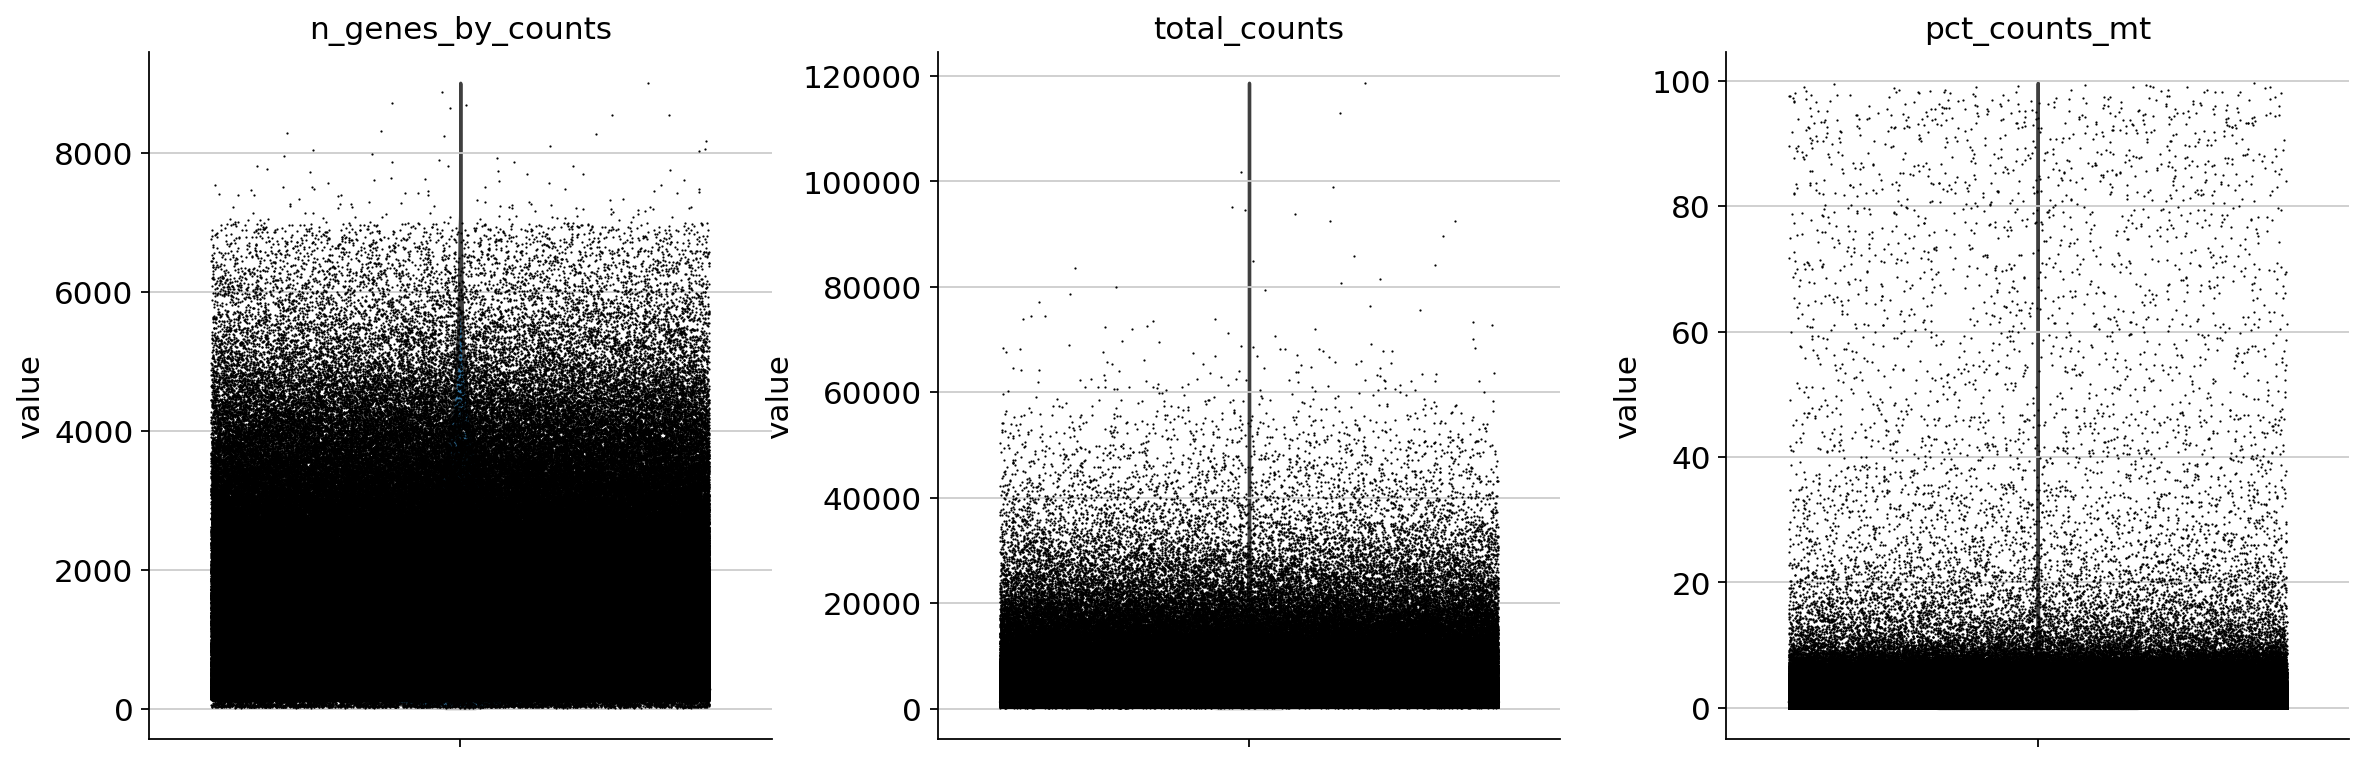

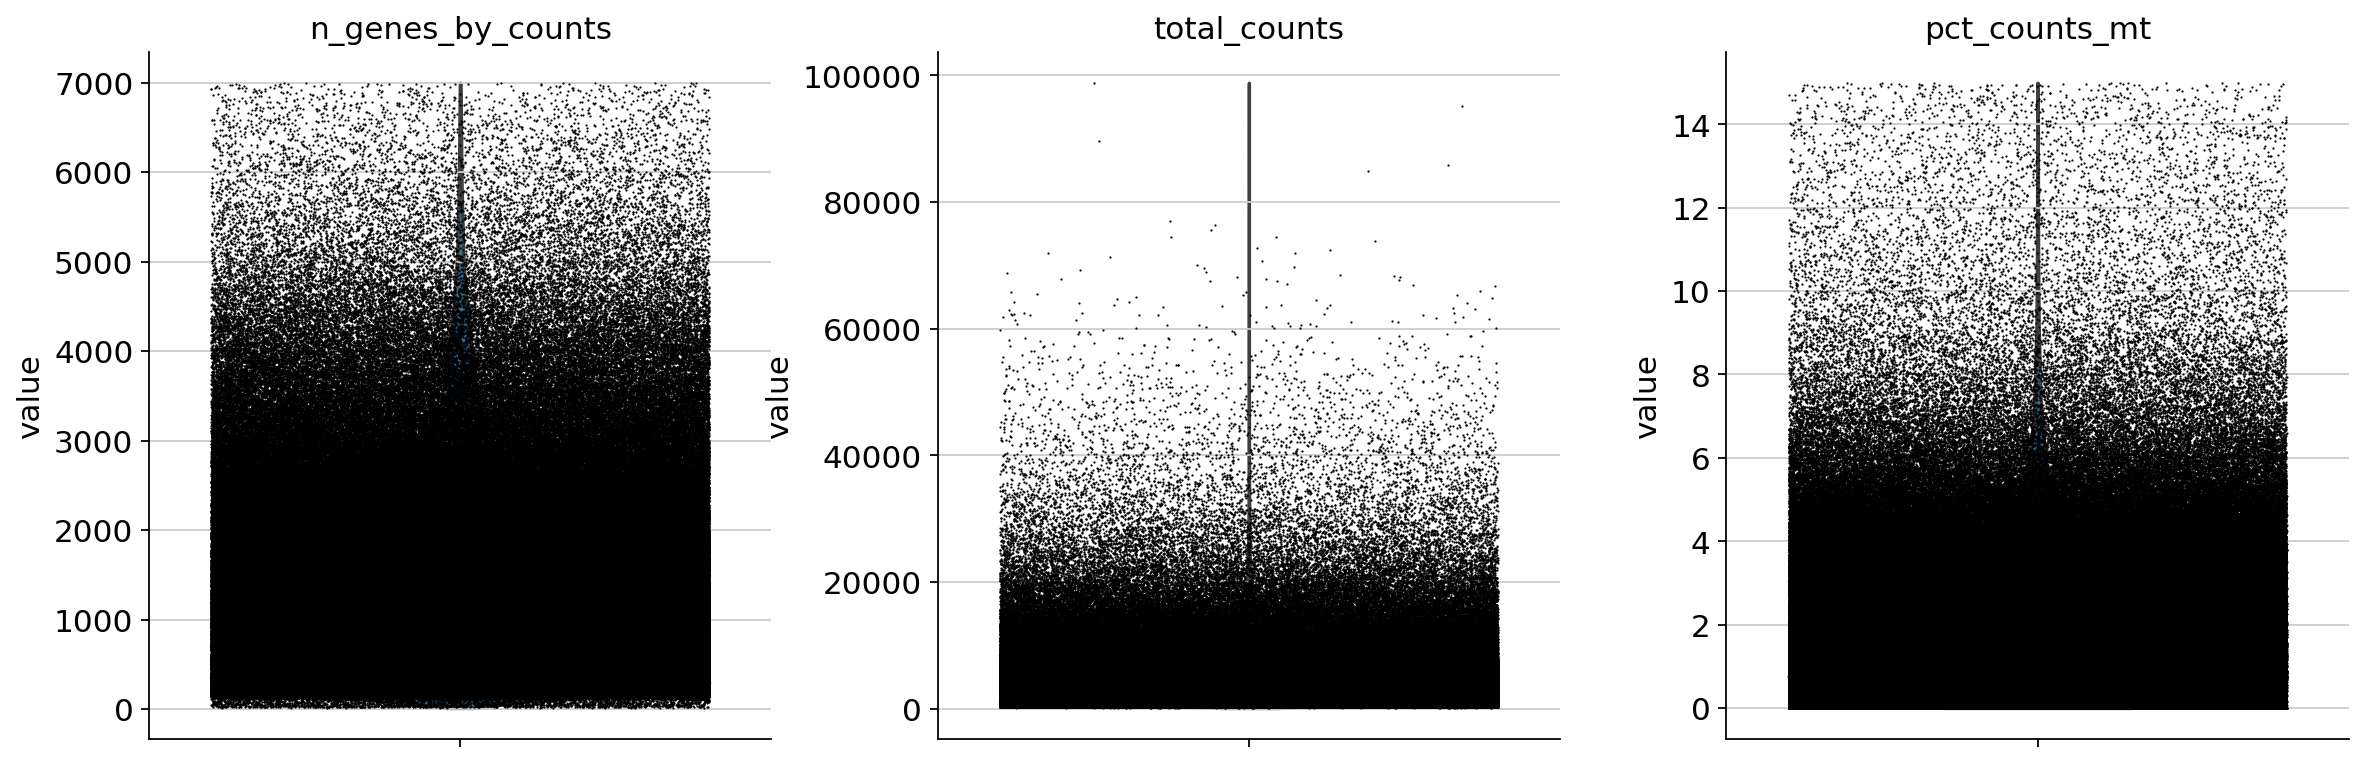

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True,save='counts.png')

adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]
adata = adata[adata.obs.total_counts < 100000, :]

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True,save='counts_postqc.png')

In [7]:
n_cells_pre = adata.shape[0]
sc.pp.filter_cells(adata, min_genes=200)
n_cells_post = adata.shape[0]
print("Number of cells removed: " + str(n_cells_pre - n_cells_post))
print("Number of cells pre-filtering: " + str(n_cells_pre))
print("Number of cells post filtering: " + str(n_cells_post))
adata.shape

filtered out 46134 cells that have less than 200 genes expressed


MemoryError: Unable to allocate 8.52 GiB for an array with shape (1143509365,) and data type float64

Then to check for the low genes

In [8]:
n_genes_pre = adata.shape[1]
sc.pp.filter_genes(adata, min_cells=10)
n_genes_post = adata.shape[1]
print("Number of genes removed: " + str(n_genes_pre - n_genes_post))
print("Number of genes pre-filtering: " + str(n_genes_pre))
print("Number of genes post filtering: " + str(n_genes_post))
adata.shape

filtered out 25408 genes that are detected in less than 10 cells
Number of genes removed: 25408
Number of genes pre-filtering: 70224
Number of genes post filtering: 44816


(779990, 44816)

In [ ]:
#adata.write('Data/postqc_step1_1408.h5ad')

In [ ]:
Using this corrected adata, we send back each studies new gene names, cells and counts

In [9]:
for study in np.unique(adata.obs['study']):
    print(study)
    study_subset = adata[adata.obs['study'] == study].copy()
    
    original_study = studies[12] #mouse covid being the first object in the list
    for dataset in studies:
        if study in np.unique(dataset.obs['study']):
            original_study = dataset[dataset.obs['study'] == study].copy()
            break
    new_subset_genes = study_subset.var_names.intersection(original_study.var_names)
    new_subset_cells = study_subset.obs_names.intersection(original_study.obs_names)
    new_subset = original_study[new_subset_cells,new_subset_genes]
    print(new_subset.shape)
    #print(new_subset.X.data)
    #new_subset.raw = new_subset.X.copy()
    new_subset.write("Data/Individual_studies/postQC/"+study+".h5ad")

Mouse_Age
(14304, 20780)
Mouse_COPD_SHAM_SARSCov2
(60941, 25633)
Mouse_Cancer
(15915, 26497)
Mouse_Copd
(70244, 21321)
Mouse_Copd_Covid
(27799, 32028)
Mouse_Covid
(37294, 34505)
Mouse_Herpesvirus
(28388, 21199)
Mouse_Hyperoxia
(47054, 26599)


MemoryError: Unable to allocate 1.03 GiB for an array with shape (137756217,) and data type float64

In [11]:
import pickle
with open('eachstudy_list.pkl', 'wb') as file:
    pickle.dump(studies, file)

MemoryError: 